In [108]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [109]:
file = open('./.env')
api = file.read()

In [153]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines, genres', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output

In [154]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [155]:
# # sort the games by the highest rating 
# df = df.sort_values('total_rating', ascending=False)

In [156]:
# # change the index of the DataFrame to the name of the game
# df = df.set_index('name')

In [157]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

In [158]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [159]:
# replace the values in our two rows with 
for row in df.loc[df.themes.isnull(), 'themes'].index: 
    df.at[row, 'themes'] = [] 
        
for row in df.loc[df.player_perspectives.isnull(), 'player_perspectives'].index: 
    df.at[row, 'player_perspectives'] = [] 
    


In [160]:
df = df.fillna(' ')

In [161]:
# getting codes for each column 

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [162]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)

In [163]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [164]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [165]:
# round off the digits by 2 decimal places
df['critic_review_rating']= round(df['critic_review_rating'], 2)
df['popularity']= round(df['popularity'], 2)
df['player_review_rating']= round(df['player_review_rating'], 2)
df['player_review_rating_count']= round(df['player_review_rating_count'], 2)
df['total_review_rating']= round(df['total_review_rating'], 2)

In [166]:
# created dictionary with keys as game_mode and values as the corresponding ID
game_modes = {'Single Player':1, 
              'Multiplayer':2 , 
              'Co-operative':3, 
              'Split Screen':4, 
              'Massively Multiplayer Online':5}  

In [167]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [168]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [169]:
#created dictionary with keys as platform and values as corresponding ID for each platform
platforms = {'Linux': 3,
'Wii': 5 ,
'PC': 6,
'PS3': 9,
'Xbox': 11,
'Xbox 360':12,
'Mac': 14,
'Nintendo DS':20,
'Android':34,
'Xbox Live Arcade':36,
'Nintendo 3DS': 37,
'iOS':39,
'Wii U':41,
'PlayStation Network':45,
'PlayStation Vita':46,
'PS4':48,
'Xbox One':49,
'Arcade':52,
'Ouya':72,
'Windows Phone':74,
'SteamOS':92,
'Nintendo Switch':130,
'Nintendo DSi':159}

In [170]:
#goes through each list in the platform column and creates a dummy variable for each platform type and adds a boolean expression if the game in question is offered on that platform
for platform in platforms.keys():
    df[platform] = df.platforms.apply(lambda plat_list: platforms[platform] in plat_list) 

In [171]:
themes = {'Action':1,
    'Fantasy': 17,
    'Science-Fiction': 18,
    'Horror': 19,
    'Thriller': 20,
    'Survival': 21,
    'Historical': 22,
    'Stealth': 23,
    'Comedy': 27,
    'Business': 28,
    'Drama': 31,
    'Non-Fiction': 32,
    'Sandbox': 33,
    'Educational': 34,
    'Kids': 35,
    'Open-world': 38,
    'Warfare': 39,
    'Erotic': 42,
    'Mystery': 43 }

In [172]:
#perform the repeated for loop on the them column and then drop the theme column
for theme in themes.keys():
    df[theme] = df.themes.apply(lambda theme_list: themes[theme] in theme_list)

In [173]:
#repeat for player_perspectives
player_perspectives = {'First-Person':1,
    'Third-Person': 2,
    'Bird-view': 3,
    'Side-view': 4,
    'Text': 5,
    'Aural': 6,
    'Virtual Reality': 7}

In [174]:
for player_perspective in player_perspectives.keys():
    df[player_perspective] = df.player_perspectives.apply(lambda pp_list: player_perspectives[player_perspective] in pp_list)

In [175]:
#repeating the process for genres defining our dictionary
genres = {'Simulator':13,
'Tactical':24,
'Quiz/Trivia':26,
'Fighting':4,
'Strategy':15,
'Adventure':31,
'Role-playing (RPG)':12,
'Shooter':5,
'Music':7,
'Indie':32,
'Turn-based strategy (TBS)':16,
'Pinball':30,
'Puzzle':9,
'Real Time Strategy (RTS)':11,
'Hack and slash/Beat ’em up':25,
'Platform':8,
'Racing':10,
'Sport':14,
'Arcade':33,
'Point-and-click':2}

In [176]:
for genre in genres.keys():
    df[genre] = df.genres.apply(lambda genre_list: genres[genre] in genre_list)

In [177]:
df = df.drop(['platforms'], axis=1) 

In [178]:
df = df.drop(['genres'], axis=1) 

In [179]:
df = df.drop(['game_modes'], axis=1)

In [180]:
df = df.drop(['player_perspectives'], axis=1)

In [181]:
df = df.drop(['themes'], axis=1)

In [182]:
# change order of our data frame
# df = df[['name','','','']]

In [186]:
df.head(1)

,critic_review_rating,critic_review_count,release_date,game_engines,hypes,name,popularity,player_review_rating,player_review_rating_count,total_review_rating,...,Indie,Turn-based strategy (TBS),Pinball,Puzzle,Real Time Strategy (RTS),Hack and slash/Beat ’em up,Platform,Racing,Sport,Point-and-click
0,87.94,19,2014-11-18,[491],9,Dragon Age: Inquisition,47.65,84.6,487,86.27,...,False,False,False,False,False,False,False,False,False,False


# Did video games get better or worse overtime?

In [183]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_year']).mean()

Text(0.5, 1.0, 'Average rating of the top game by year')

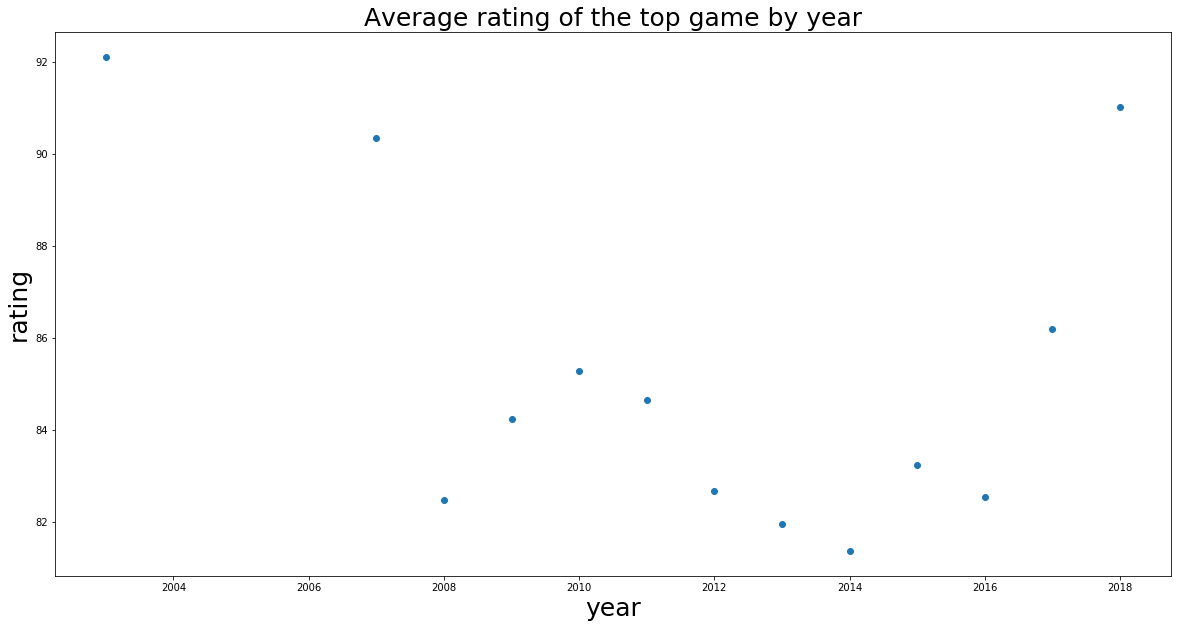

In [184]:
new_figure = plt.figure(figsize=(20,10))
ax = new_figure.add_subplot(111)
ax.scatter(release_year_mean.index , release_year_mean.total_review_rating)
ax.set_xlabel('year', size=25)
ax.set_ylabel('rating', size=25)
ax.set_title('Average rating of the top game by year', size=25)